In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import yahooquery as yq
import mplfinance as mpf
import matplotlib.pyplot as plt

# For data exporting
from io import BytesIO
import xlsxwriter
from pyxlsb import open_workbook as open_xlsb
from yahooquery import Ticker
from datetime import timedelta

from datetime import datetime
import pytz


%matplotlib inline


In [51]:
aapl = Ticker('aapl')
aapl.income_statement(frequency='q')


,asOfDate,periodType,currencyCode,BasicAverageShares,BasicEPS,CostOfRevenue,DilutedAverageShares,DilutedEPS,DilutedNIAvailtoComStockholders,EBIT,...,ReconciledCostOfRevenue,ReconciledDepreciation,ResearchAndDevelopment,SellingGeneralAndAdministration,TaxEffectOfUnusualItems,TaxProvision,TaxRateForCalcs,TotalExpenses,TotalOperatingIncomeAsReported,TotalRevenue
symbol,,,,,,,,,,,,,,,,,,,,,
aapl,2023-03-31,3M,USD,1.578715e+10,1.53,5.286000e+10,1.584705e+10,1.52,2.416000e+10,2.931200e+10,...,5.286000e+10,2.898000e+09,7.457000e+09,6.201000e+09,0.0,4.222000e+09,0.149000,6.651800e+10,2.831800e+10,9.483600e+10
aapl,2023-06-30,3M,USD,1.569761e+10,1.27,4.538400e+10,1.577502e+10,1.26,1.988100e+10,2.373100e+10,...,4.538400e+10,3.052000e+09,7.442000e+09,5.973000e+09,0.0,2.852000e+09,0.125000,5.879900e+10,2.299800e+10,8.179700e+10
aapl,2023-09-30,3M,USD,1.559943e+10,1.47,4.907100e+10,1.567240e+10,1.46,2.295600e+10,2.800000e+10,...,4.907100e+10,2.653000e+09,7.307000e+09,6.151000e+09,0.0,4.042000e+09,0.149715,6.252900e+10,2.696900e+10,8.949800e+10
aapl,2023-09-30,TTM,USD,1.574423e+10,6.16,NaN,1.581255e+10,6.13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aapl,2023-12-31,3M,USD,1.550976e+10,2.19,6.472000e+10,1.557664e+10,2.18,3.391600e+10,4.037300e+10,...,6.472000e+10,2.848000e+09,7.696000e+09,6.786000e+09,0.0,6.407000e+09,0.159000,7.920200e+10,4.037300e+10,1.195750e+11
aapl,2023-12-31,TTM,USD,1.564849e+10,6.46,2.120350e+11,1.571778e+10,6.43,1.009130e+11,1.220260e+11,...,2.120350e+11,1.145100e+10,2.990200e+10,2.511100e+10,0.0,1.752300e+10,0.147953,2.670480e+11,1.186580e+11,3.857060e+11


In [46]:
def get_current_price(ticker_symbol):
    try:
        ticker = Ticker(ticker_symbol)
        return ticker.financial_data[str(ticker_symbol)]['currentPrice']
    except:
        return None  # 

In [34]:
get_current_price('AAPL')

175.965

In [48]:
ticker=pd.read_csv('tickers.csv').dropna()
mask = ticker['Ticker'] != "--"
ticker = ticker[mask]
ticker['CurrentPrice'] = ticker['Ticker'].apply(lambda x: get_current_price(x))
filtered_ticker = ticker[ticker['CurrentPrice'] > 400]
filtered_ticker

,Ticker,CurrentPrice
0,MSFT,421.5400
2,NVDA,879.7500
4,META,510.2854
8,LLY,752.0000
9,AVGO,1343.9700
...,...,...
1006,CACC,555.6000
1174,GHC,712.6250
1496,DDS,406.3900
1738,NWLI,490.8000


In [ ]:
for tickers in ticker['Ticker']:
    ticker = Ticker(stock)
    


In [24]:
ticker = Ticker('MSFT')
ticker.financial_data['MSFT']['currentPrice']

421.67

In [5]:
def is_market_hours():
    eastern = pytz.timezone('US/Eastern')
    now = datetime.now(eastern)
    market_open = now.replace(hour=9, minute=30, second=0, microsecond=0)
    market_close = now.replace(hour=16, minute=0, second=0, microsecond=0)
    return market_open <= now <= market_close

#### Stock Selection Criteria

In [12]:
#The last four quarterly EPS are all greater than expected.    
def eps_greater_than_expected(ticker):
    earnings = ticker.earning_history
    earnings['eps_greater'] = earnings.apply(compare_eps, axis=1)
    
    if (earnings['eps_greater'] == 'Yes').all():
        result= 'Passed'
    else:
        result= 'Failed'
                
    return result

def compare_eps(row):
    if row['epsActual'] > row['epsEstimate']:
        return 'Yes'
    else:
        return 'No'

#The past 50 days’ volume changing rate is between 0~3%. (The period is discussable)
def past_50_days_volume_change(ticker):
    if is_market_hours():
        price = ticker.history(period='51d')[:-1]
    else:
        price = ticker.history(period='50d')
    price['daily_change_rate']=price['volume'].pct_change()
    price=price.dropna()

    if (price['daily_change_rate'] <= 0.03).all():
        result= 'Passed'
    else:
        result= 'Failed'
                
    return result

#The stock price >= $12.
def stock_price_greater_12(ticker):
    price = ticker.history()
    current_stock_price= price.iloc[-1]['close']
    
    if current_stock_price >= 12:
        result= 'Passed'
    else:
        result= 'Failed'               
    return result

# #The current price change from 52wk high >= -15%.
# def price_change_52wk(stock):
#     ticker = Ticker(stock)
#     price_change=ticker.key_stats[stock]['52WeekChange']

#     if price_change>= -0.15:
#         result= 'Passed'
#     else:
#         result= 'Failed'                
#     return result

def price_change_52wk(stock):
    ticker = Ticker(stock)
    modules = 'assetProfile earnings defaultKeyStatistics'

    price_change=ticker.get_modules(modules)[stock]['defaultKeyStatistics']['52WeekChange']

    if price_change>= -0.15:
        result= 'Passed'
    else:
        result= 'Failed'                
    return result

#The past 50 days' average volume >= 2000k. (The period is discussable)
def past_50_days_avg_volume(ticker):
    if is_market_hours():
        price = ticker.history(period='51d')[:-1]
    else:
        price = ticker.history(period='50d')
        
    avg_volume=price['volume'].mean()

    if avg_volume>= 2000000:
        result= 'Passed'
    else:
        result= 'Failed'
                
    return result

#The current price > MA20
def cur_price_ma20(ticker):
    
    if is_market_hours():
        price = ticker.history(period='21d')[:-1]
    else:
        price = ticker.history(period='20d')

    current_stock_price= price.iloc[-1]['close']
    ma20=price['close'].mean()
    
    if current_stock_price >= ma20:
        result= 'Passed'
    else:
        result= 'Failed'               
    return result

#MA10 > MA50
def ma10_ma50(ticker):
    if is_market_hours():
        price = ticker.history(period='51d')[:-1]
    else:
        price = ticker.history(period='50d')

    ma10=price[-10:]['close'].mean()
    ma50=price['close'].mean()
    
    if ma10 >= ma50:
        result= 'Passed'
    else:
        result= 'Failed'               
    return result

#MA20 > MA200
def ma20_ma200(ticker):
    if is_market_hours():
        price = ticker.history(period='201d')[:-1]
    else:
        price = ticker.history(period='200d')
    ma20=price[-20:]['close'].mean()
    ma200=price['close'].mean()
    
    if ma20 >= ma200:
        result= 'Passed'
    else:
        result= 'Failed'               
    return result

#MA50 > MA200
def ma50_ma200(ticker):
    if is_market_hours():
        price = ticker.history(period='201d')[:-1]
    else:
        price = ticker.history(period='200d')
    ma50=price[-50:]['close'].mean()
    ma200=price['close'].mean()
    
    if ma50 >= ma200:
        result= 'Passed'
    else:
        result= 'Failed'               
    return result

def compare_ma(ticker, day1, day2):
    day_2_add_1 = day2 + 1
    if is_market_hours():
        price = ticker.history(period=day_2_add_1)[:-1]
    else:
        price = ticker.history(period=day2)
    ma_day1=price[-day1:]['close'].mean()
    ma_day2=price['close'].mean()
    
    if ma_day1 >= ma_day2:
        result= 'Passed'
    else:
        result= 'Failed'               
    return result

In [13]:
ticker = Ticker('aapl')
price = ticker.history(period='50d')
price

/opt/homebrew/lib/python3.10/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/opt/homebrew/lib/python3.10/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


open        high         low       close     volume  \
symbol date                                                                    
aapl   2024-01-25  195.220001  196.270004  193.110001  194.169998   54822100   
       2024-01-26  194.270004  194.759995  191.940002  192.419998   44594000   
       2024-01-29  192.009995  192.199997  189.580002  191.729996   47145600   
       2024-01-30  190.940002  191.800003  187.470001  188.039993   55859400   
       2024-01-31  187.039993  187.100006  184.350006  184.399994   55467800   
       2024-02-01  183.990005  186.949997  183.820007  186.860001   64885400   
       2024-02-02  179.860001  187.330002  179.250000  185.850006  102518000   
       2024-02-05  188.149994  189.250000  185.839996  187.679993   69668800   
       2024-02-06  186.860001  189.309998  186.770004  189.300003   43490800   
       2024-02-07  190.639999  191.050003  188.610001  189.410004   53439000   
       2024-02-08  189.389999  189.539993  187.350006  188.320007   40962000   
       2024-02-09  188.649994  189.990005  188.000000  188.850006   45155200   
       2024-02-12  188.419998  188.669998  186.789993  187.149994   41781900   
       2024-02-13  185.770004  186.210007  183.509995  185.039993   56529500   
       2024-02-14  185.320007  185.529999  182.440002  184.149994   54630500   
       2024-02-15  183.550003  184.490005  181.350006  183.860001   65434500   
       2024-02-16  183.419998  184.850006  181.669998  182.309998   49701400   
       2024-02-20  181.789993  182.429993  180.000000  181.559998   53665600   
       2024-02-21  181.940002  182.889999  180.660004  182.320007   41529700   
       2024-02-22  183.479996  184.960007  182.460007  184.369995   52292200   
       2024-02-23  185.009995  185.039993  182.229996  182.520004   45119700   
       2024-02-26  182.240005  182.759995  180.649994  181.160004   40867400   
       2024-02-27  181.100006  183.919998  179.559998  182.630005   54318900   
       2024-02-28  182.509995  183.119995  180.130005  181.419998   48953900   
       2024-02-29  181.270004  182.570007  179.529999  180.750000  136682600   
       2024-03-01  179.550003  180.529999  177.380005  179.660004   73488000   
       2024-03-04  176.149994  176.899994  173.789993  175.100006   81510100   
       2024-03-05  170.759995  172.039993  169.619995  170.119995   95132400   
       2024-03-06  171.059998  171.240005  168.679993  169.119995   68587700   
       2024-03-07  169.149994  170.729996  168.490005  169.000000   71765100   
       2024-03-08  169.000000  173.699997  168.940002  170.729996   76114600   
       2024-03-11  172.940002  174.380005  172.050003  172.750000   60139500   
       2024-03-12  173.149994  174.029999  171.009995  173.229996   59825400   
       2024-03-13  172.770004  173.190002  170.759995  171.130005   52488700   
       2024-03-14  172.910004  174.309998  172.050003  173.000000   72913500   
       2024-03-15  171.169998  172.619995  170.289993  172.619995  121664700   
       2024-03-18  175.570007  177.710007  173.520004  173.720001   75604200   
       2024-03-19  174.339996  176.610001  173.029999  176.080002   55215200   
       2024-03-20  175.720001  178.669998  175.089996  178.669998   53423100   
       2024-03-21  177.050003  177.490005  170.839996  171.369995  106181300   
       2024-03-22  171.759995  173.050003  170.059998  172.279999   71106600   
       2024-03-25  170.570007  171.940002  169.449997  170.850006   54288300   
       2024-03-26  170.000000  171.419998  169.580002  169.710007   57388400   
       2024-03-27  170.410004  173.600006  170.110001  173.309998   60273300   
       2024-03-28  171.750000  172.229996  170.509995  171.479996   65672700   
       2024-04-01  171.190002  171.250000  169.479996  170.029999   46240500   
       2024-04-02  169.080002  169.339996  168.229996  168.839996   49329500   
       2024-04-03  168.789993  170.679993  168.580002  169.649994   47602100   
       2024-04-04  170.28

#### Plot past 3wk's candlestick chart

In [4]:
def plot_candlestick(stock):
    ticker = Ticker(stock)
    if is_market_hours():
        price = ticker.history(period='21d')[:-1]
    else:
        price = ticker.history(period='20d')
    
    price=price.reset_index()
    price['date'] = pd.to_datetime(price['date'])
    
    price=price.set_index('date')
    plot=mpf.plot(price, type='candle', style='charles')

    return plot

/opt/homebrew/lib/python3.10/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


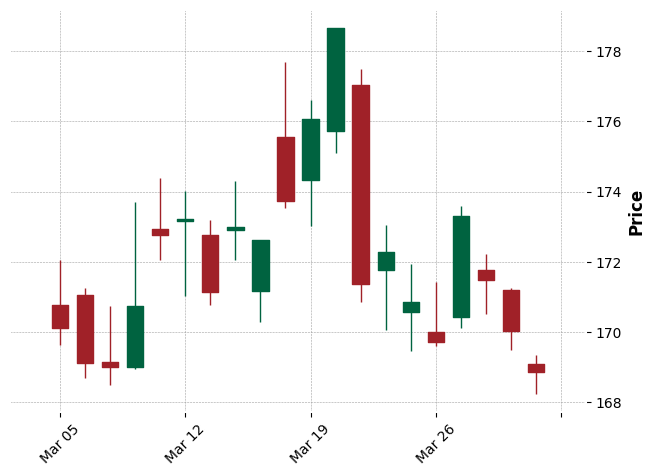

In [5]:
plot_candlestick('aapl')

#### Return Result


In [13]:
def stock_selection(stock):
    ticker = Ticker(stock)
    
    data = np.array([['The last five quarterly EPS are all greater than expected.', eps_greater_than_expected(ticker)],
                    ['The past 50 days’ volume changing rate is between 0~3%.', past_50_days_volume_change(ticker)],
                    ['The stock price >= $12.', stock_price_greater_12(ticker)],
                    ['The current price change from 52wk high >= -15%.', price_change_52wk(stock)],
                    ['The past 50 days avg volume >= 2000k. ', past_50_days_avg_volume(ticker)],
                    ['The current price > MA20.', cur_price_ma20(ticker)],
                    ['MA10 > MA50.', ma10_ma50(ticker)],
                    ['MA20 > MA200.', ma20_ma200(ticker)],
                    ['MA50 > MA200.', ma50_ma200(ticker)],
                    ])
    df = pd.DataFrame(data, columns=['Criteria', 'Result'])
    
    #df.to_excel('stock_selection_result.xlsx', index=False, engine='xlsxwriter')

    return df

In [9]:
ticker = Ticker('aapl')
price_change=ticker.key_stats['aapl']
price_change

{'maxAge': 1,
 'priceHint': 2,
 'enterpriseValue': 2948922081280,
 'forwardPE': 26.26141,
 'profitMargins': 0.26306,
 'floatShares': 15308474083,
 'sharesOutstanding': 15334099968,
 'sharesShort': 94308265,
 'sharesShortPriorMonth': 108782648,
 'sharesShortPreviousMonthDate': '2024-03-28 08:00:00',
 'dateShortInterest': '2024-04-30 08:00:00',
 'sharesPercentSharesOut': 0.0062,
 'heldPercentInsiders': 0.052199997,
 'heldPercentInstitutions': 0.57553,
 'shortRatio': 1.66,
 'shortPercentOfFloat': 0.0062,
 'beta': 1.264,
 'category': None,
 'bookValue': 4.837,
 'priceToBook': 39.25367,
 'fundFamily': None,
 'legalType': None,
 'lastFiscalYearEnd': '2023-09-30 08:00:00',
 'nextFiscalYearEnd': '2024-09-30 08:00:00',
 'mostRecentQuarter': '2024-03-30 08:00:00',
 'earningsQuarterlyGrowth': -0.022,
 'netIncomeToCommon': 100389003264,
 'trailingEps': 6.44,
 'forwardEps': 7.23,
 'pegRatio': 2.62,
 'lastSplitFactor': '4:1',
 'lastSplitDate': '2020-08-31 08:00:00',
 'enterpriseToRevenue': 7.727,
 '

In [ ]:
def price_change_52wk(stock):
    ticker = Ticker(stock)
    modules = 'assetProfile earnings defaultKeyStatistics'

    price_change=ticker.get_modules(modules)[stock]['defaultKeyStatistics']['52WeekChange']

    if price_change>= -0.15:
        result= 'Passed'
    else:
        result= 'Failed'                
    return result

In [11]:
aapl = Ticker('aapl')
modules = 'assetProfile earnings defaultKeyStatistics'
aapl.get_modules(modules)['aapl']['defaultKeyStatistics']['52WeekChange']

0.08995402

In [ ]:
ticker = Ticker(stock)
    price_change=ticker.key_stats[]['52WeekChange']

    if price_change>= -0.15:
        result= 'Passed'
    else:
        result= 'Failed'                
    return result

In [ ]:
def price_change_52wk(stock):
    ticker = Ticker(stock)
    price_change=ticker.key_stats[stock]['52WeekChange']

    if price_change>= -0.15:
        result= 'Passed'
    else:
        result= 'Failed'                
    return result

In [14]:
stock_selection('aapl')

/opt/homebrew/lib/python3.10/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/opt/homebrew/lib/python3.10/site-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/opt/homebrew/lib/python3.10/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be

,Criteria,Result
0,The last five quarterly EPS are all greater th...,Passed
1,The past 50 days’ volume changing rate is betw...,Failed
2,The stock price >= $12.,Passed
3,The current price change from 52wk high >= -15%.,Passed
4,The past 50 days avg volume >= 2000k.,Passed
5,The current price > MA20.,Passed
6,MA10 > MA50.,Passed
7,MA20 > MA200.,Failed
8,MA50 > MA200.,Failed


#### Page Setup

In [8]:
st.set_page_config(  # Alternate names: setup_page, page, layout
	layout="wide",  # Can be "centered" or "wide". In the future also "dashboard", etc.
	initial_sidebar_state="auto",  # Can be "auto", "expanded", "collapsed"
	page_title='Stock Selection System',  # String or None. Strings get appended with "• Streamlit".
	page_icon='jams_icon.ico',  # String, anything supported by st.image, or None.
)
image_url = "https://i.imgur.com/cnx9XYd.png"
st.image(image_url, output_format="PNG", width=200)

2024-04-03 23:15:27.089 
  command:

    streamlit run /Users/sylvialiang/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [ ]:
def main():
    st.title('Stock Selection System')
    
    # Text input for stock ticker
    ticker_input = st.text_input('Enter company\'s ticker:')
    
    # Button to trigger stock selection
    if st.button('Run Stock Selection'):
        # Perform stock selection
        df = stock_selection(ticker_input)
        
        # Display resulting DataFrame
        if df is not None:
            st.subheader('Stock Data:')
            st.dataframe(df)
        else:
            st.write('No data available for the specified ticker.')

if __name__ == '__main__':
    main()

In [ ]:
# Page setup
st.set_page_config(  # Alternate names: setup_page, page, layout
	layout="wide",  # Can be "centered" or "wide". In the future also "dashboard", etc.
	initial_sidebar_state="auto",  # Can be "auto", "expanded", "collapsed"
	page_title='Stock Selection System',  # String or None. Strings get appended with "• Streamlit".
	page_icon='jams_icon.ico',  # String, anything supported by st.image, or None.
)
image_url = "https://i.imgur.com/cnx9XYd.png"
st.image(image_url, output_format="PNG", width=200)
header = '<p style="font-family:Times New Roman; color:black; font-size: 30px;">Stock Selection System</p>'
st.markdown(header, unsafe_allow_html=True)

col1, col2 = st.columns([1,3])
with col1:
    stock = st.text_input('Enter company\'s ticker:')
with col2:
    competitors = st.text_input('wrap ticker with quotation, will fix this later')
count = 0

plot = None

fetch_button = st.button('Check')
if fetch_button:
    df=stock_selection(stock)
    plot=plot_candlestick(stock)

# Display DataFrame
    st.subheader('Stock Data:')
    st.dataframe(df)
    
# Display Plot
st.subheader('Stock Price Trend:')
st.pyplot(plot)

# Display rights
def load_css(file_name):
    with open(file_name) as f:
        st.markdown(f'<style>{f.read()}</style>', unsafe_allow_html=True)
load_css('example.css')
# Footer
st.markdown(
    """
    <div class="footer">
        Developed by JAMS Investment. All rights reserved. Version 2 2023.11
    </div>
    """,
    unsafe_allow_html=True
)
